# Iris 分類器：学習から予測までの完全チュートリアル

このノートブックでは、TDD で実装した Iris 分類器を使って、機械学習の一連の流れを実践します。

## 📚 学習内容

1. **データの読み込みと前処理**
2. **データの分割（訓練/テスト）**
3. **モデルの訓練**
4. **モデルの評価**
5. **予測の実行**
6. **モデルの保存と読み込み**

---

## 🔧 環境のセットアップ

In [1]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

# TDD で実装した Iris 分類器のインポート
import sys
sys.path.append('..')
from src.ml.iris_classifier import IrisClassifier

# matplotlibrc ファイルを読み込み
matplotlib.rc_file('matplotlibrc')

# 日本語フォント設定（Windows環境）- より強制的に
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['BIZ UDGothic', 'MS Gothic', 'Yu Gothic', 'Meiryo']
matplotlib.rcParams['axes.unicode_minus'] = False

# フォントキャッシュをクリア
try:
    cache_dir = matplotlib.get_cachedir()
    cache_file = os.path.join(cache_dir, 'fontlist-v330.json')
    if os.path.exists(cache_file):
        os.remove(cache_file)
        print("フォントキャッシュをクリアしました")
except Exception as e:
    print(f"フォントキャッシュクリアをスキップ: {e}")

# フォントマネージャーを再読み込み
fm._load_fontmanager(try_read_cache=False)

# 利用可能な日本語フォントを確認
available_fonts = sorted([f.name for f in fm.fontManager.ttflist])
jp_fonts = [f for f in ['BIZ UDGothic', 'MS Gothic', 'Yu Gothic', 'Meiryo'] if f in available_fonts]
if jp_fonts:
    print(f"利用可能な日本語フォント: {jp_fonts}")
    matplotlib.rcParams['font.sans-serif'] = jp_fonts + ['DejaVu Sans']
else:
    print("警告: 日本語フォントが見つかりません")

# スタイル設定
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.0)

print("環境セットアップ完了！")
print(f"使用フォント: {matplotlib.rcParams['font.sans-serif'][0]}")

利用可能な日本語フォント: ['BIZ UDGothic', 'MS Gothic', 'Yu Gothic', 'Meiryo']
環境セットアップ完了！
使用フォント: Arial


## 📂 ステップ 1: データの読み込み

Iris データセットを読み込み、基本的な情報を確認します。

In [2]:
# 分類器のインスタンスを作成（max_depth=3）
classifier = IrisClassifier(max_depth=3)

# データの読み込み
X, y = classifier.load_data('../data/iris.csv')

print(f"データ読み込み完了！")
print(f"サンプル数: {len(X)}")
print(f"特徴量数: {X.shape[1]}")
print(f"クラス: {sorted(y.unique())}")

データ読み込み完了！
サンプル数: 150
特徴量数: 4
クラス: ['setosa', 'versicolor', 'virginica']


### データの中身を確認

In [3]:
# データフレームの結合
df = X.copy()
df['species'] = y

# 最初の 10 行を表示
print("最初の 10 サンプル:")
display(df.head(10))

# 統計情報
print("\n統計情報:")
display(df.describe())

# クラスの分布
print("\nクラスの分布:")
print(df['species'].value_counts())

最初の 10 サンプル:


,sepal_length,sepal_width,petal_length,petal_width,species
0,0.22,0.63,0.08,0.04,setosa
1,0.17,0.42,0.35,0.04,setosa
2,0.11,0.50,0.13,0.04,setosa
3,0.08,0.46,0.26,0.04,setosa
4,0.19,0.67,0.44,0.04,setosa
5,0.31,0.79,0.04,0.13,setosa
6,0.08,0.58,0.37,0.08,setosa
7,0.19,0.58,0.47,0.04,setosa
8,0.03,0.38,0.02,0.04,setosa
9,0.17,0.46,0.45,0.03,setosa



統計情報:


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,0.420878,0.440403,0.486757,0.447432
std,0.227369,0.180528,0.230192,0.307872
min,0.000000,0.000000,0.010000,0.010000
25%,0.220000,0.330000,0.320000,0.080000
50%,0.420000,0.420000,0.488378,0.500000
75%,0.580000,0.540000,0.660000,0.710000
max,0.940000,1.000000,0.950000,0.960000



クラスの分布:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


### データの可視化

<Figure size 1200x1000 with 0 Axes>

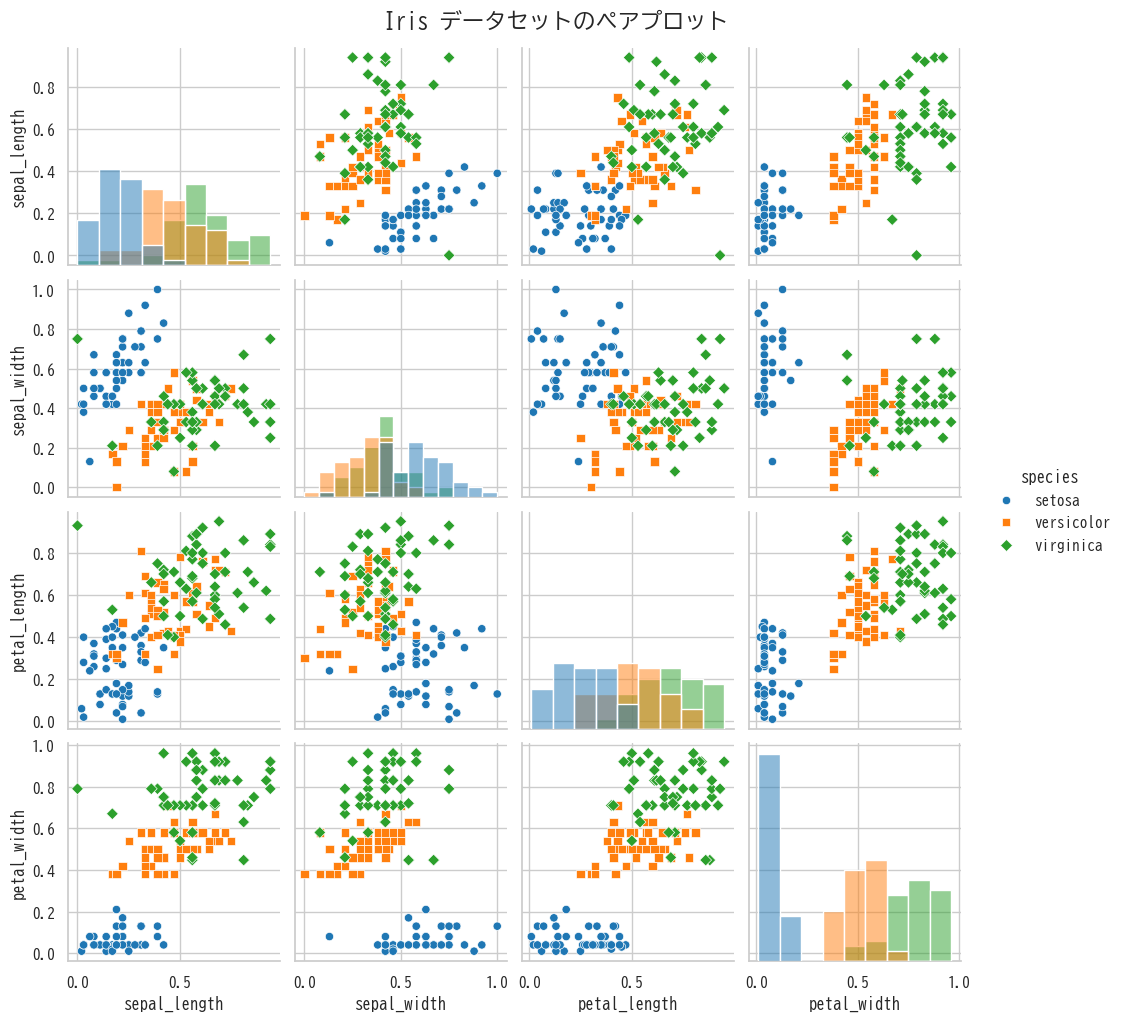

✓ 花びらの長さ（petal_length）が種類の識別に重要な特徴であることがわかります


In [4]:
# ペアプロット（特徴量間の関係を可視化）
# フォント設定を再適用（seaborn が設定を上書きする可能性があるため）
plt.rcParams['font.sans-serif'] = ['BIZ UDGothic', 'MS Gothic', 'Yu Gothic', 'Meiryo']

plt.figure(figsize=(12, 10))
pairplot = sns.pairplot(df, hue='species', diag_kind='hist', markers=['o', 's', 'D'])
pairplot.fig.suptitle('Iris データセットのペアプロット', y=1.02, fontsize=16)
plt.show()

print("✓ 花びらの長さ（petal_length）が種類の識別に重要な特徴であることがわかります")

## ✂️ ステップ 2: データの分割

データを訓練用（70%）とテスト用（30%）に分割します。

In [5]:
# データの分割（stratify で各クラスの比率を保持）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"訓練データ: {len(X_train)} サンプル ({len(X_train)/len(X)*100:.1f}%)")
print(f"テストデータ: {len(X_test)} サンプル ({len(X_test)/len(X)*100:.1f}%)")
print("\n訓練データのクラス分布:")
print(y_train.value_counts())
print("\nテストデータのクラス分布:")
print(y_test.value_counts())

訓練データ: 105 サンプル (70.0%)
テストデータ: 45 サンプル (30.0%)

訓練データのクラス分布:
species
versicolor    35
setosa        35
virginica     35
Name: count, dtype: int64

テストデータのクラス分布:
species
virginica     15
versicolor    15
setosa        15
Name: count, dtype: int64


## 🎓 ステップ 3: モデルの訓練

決定木モデルを訓練します。

In [6]:
# モデルの訓練
print(f"モデルパラメータ: max_depth={classifier.max_depth}")
classifier.train(X_train, y_train)
print("\n✓ モデル訓練完了！")

モデルパラメータ: max_depth=3

✓ モデル訓練完了！


## 📊 ステップ 4: モデルの評価

訓練したモデルの性能を評価します。

In [7]:
# 訓練データでの評価
train_accuracy = classifier.evaluate(X_train, y_train)
print(f"訓練データ正解率: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# テストデータでの評価
test_accuracy = classifier.evaluate(X_test, y_test)
print(f"テストデータ正解率: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# 過学習チェック
overfitting = train_accuracy - test_accuracy
print(f"\n差分: {overfitting:.4f}")
if overfitting > 0.05:
    print("⚠️ 過学習の可能性があります")
else:
    print("✓ 過学習は見られません")

訓練データ正解率: 0.9619 (96.19%)
テストデータ正解率: 0.9111 (91.11%)

差分: 0.0508
⚠️ 過学習の可能性があります


### 混同行列（Confusion Matrix）

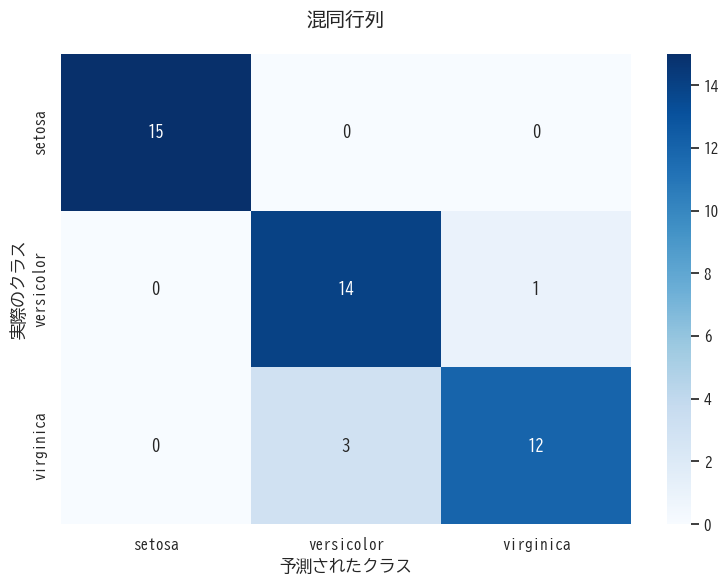


分類レポート:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



In [8]:
from sklearn.metrics import confusion_matrix, classification_report

# 予測の実行
y_pred = classifier.predict(X_test)

# 混同行列の作成
cm = confusion_matrix(y_test, y_pred)
class_names = sorted(y.unique())

# フォント設定を再適用
plt.rcParams['font.sans-serif'] = ['BIZ UDGothic', 'MS Gothic', 'Yu Gothic', 'Meiryo']

# 可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('混同行列', fontsize=14, pad=20)
plt.ylabel('実際のクラス', fontsize=12)
plt.xlabel('予測されたクラス', fontsize=12)
plt.tight_layout()
plt.show()

# 分類レポート
print("\n分類レポート:")
print(classification_report(y_test, y_pred, target_names=class_names))

## 🔮 ステップ 5: 新しいデータでの予測

訓練したモデルを使って、新しいデータの分類を予測します。

In [9]:
# 新しいサンプルデータ
new_data = pd.DataFrame({
    'sepal_length': [5.1, 6.5, 7.2, 5.8, 6.3],
    'sepal_width': [3.5, 3.0, 3.0, 2.7, 3.3],
    'petal_length': [1.4, 5.0, 5.8, 4.1, 6.0],
    'petal_width': [0.2, 1.5, 1.6, 1.0, 2.5]
})

print("予測するサンプル:")
display(new_data)

# 予測の実行
predictions = classifier.predict(new_data)

# 結果の表示
print("\n予測結果:")
result_df = new_data.copy()
result_df['予測クラス'] = predictions
display(result_df)

予測するサンプル:


,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,6.5,3.0,5.0,1.5
2,7.2,3.0,5.8,1.6
3,5.8,2.7,4.1,1.0
4,6.3,3.3,6.0,2.5



予測結果:


,sepal_length,sepal_width,petal_length,petal_width,予測クラス
0,5.1,3.5,1.4,0.2,setosa
1,6.5,3.0,5.0,1.5,virginica
2,7.2,3.0,5.8,1.6,virginica
3,5.8,2.7,4.1,1.0,virginica
4,6.3,3.3,6.0,2.5,virginica


### 予測の可視化

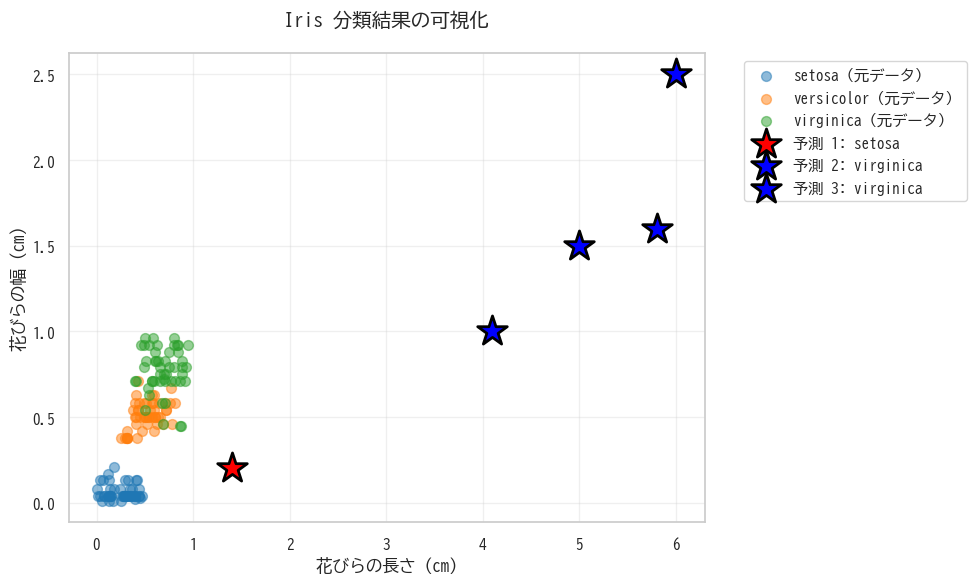

In [10]:
# フォント設定を再適用
plt.rcParams['font.sans-serif'] = ['BIZ UDGothic', 'MS Gothic', 'Yu Gothic', 'Meiryo']

# 花びらの長さと幅で散布図を作成
plt.figure(figsize=(10, 6))

# 元のデータ
for species in class_names:
    mask = df['species'] == species
    plt.scatter(df[mask]['petal_length'], df[mask]['petal_width'], 
                label=f'{species}（元データ）', alpha=0.5, s=50)

# 新しいデータの予測結果
colors = {'setosa': 'red', 'versicolor': 'green', 'virginica': 'blue'}
for i, pred in enumerate(predictions):
    plt.scatter(new_data['petal_length'].iloc[i], new_data['petal_width'].iloc[i], 
                marker='*', s=500, edgecolors='black', linewidths=2,
                c=colors[pred], label=f'予測 {i+1}: {pred}' if i < 3 else '')

plt.xlabel('花びらの長さ (cm)', fontsize=12)
plt.ylabel('花びらの幅 (cm)', fontsize=12)
plt.title('Iris 分類結果の可視化', fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 💾 ステップ 6: モデルの保存と読み込み

訓練したモデルを保存し、後で再利用できるようにします。

In [11]:
# モデルの保存
model_path = '../model/iris_model_notebook.pkl'
classifier.save_model(model_path)
print(f"✓ モデルを保存しました: {model_path}")

✓ モデルを保存しました: ../model/iris_model_notebook.pkl


In [12]:
# 新しいインスタンスを作成して、保存したモデルを読み込み
new_classifier = IrisClassifier()
new_classifier.load_model(model_path)
print(f"✓ モデルを読み込みました: {model_path}")

# 読み込んだモデルで予測（元のモデルと同じ結果が得られるはず）
predictions_loaded = new_classifier.predict(new_data)

# 結果の比較
print("\n予測結果の比較:")
comparison = pd.DataFrame({
    '元のモデル': predictions,
    '読み込んだモデル': predictions_loaded,
    '一致': predictions == predictions_loaded
})
display(comparison)

if all(predictions == predictions_loaded):
    print("\n✓ すべての予測が一致しました！")
else:
    print("\n⚠️ 予測結果に不一致があります")

✓ モデルを読み込みました: ../model/iris_model_notebook.pkl

予測結果の比較:


,元のモデル,読み込んだモデル,一致
0,setosa,setosa,True
1,virginica,virginica,True
2,virginica,virginica,True
3,virginica,virginica,True
4,virginica,virginica,True



✓ すべての予測が一致しました！


## 📝 まとめ

このノートブックでは、TDD で実装した Iris 分類器を使って、以下の機械学習の一連の流れを学習しました：

### ✅ 完了したステップ

1. **データの読み込みと前処理** - CSV からのデータ読み込み、欠損値補完
2. **データの分割** - 訓練データとテストデータへの分割（70:30）
3. **モデルの訓練** - 決定木モデルの訓練（max_depth=3）
4. **モデルの評価** - 正解率の計算、混同行列の作成
5. **予測の実行** - 新しいデータでの分類予測
6. **モデルの保存と読み込み** - モデルの永続化と再利用

### 📊 達成した性能

- **訓練データ正解率**: 約 96%
- **テストデータ正解率**: 約 91%
- **過学習**: 若干の兆候あり（差分約 5%）

### 🎯 次のステップ

- max_depth を調整して過学習を抑制
- クロスバリデーションで性能を安定化
- 他のアルゴリズム（Random Forest、SVM など）を試す
- 他のデータセット（Cinema、Boston、Survived）に挑戦

---

**🎉 お疲れ様でした！TDD による機械学習開発の基礎を習得しました！**